In [143]:
'''
Start with array of cells for each row
======================================
First row will be ignored => [Code | Student Name | English Name | 1 | 2 | 3]

For each row:
1- Check for user choosed method (OCR or features + classifier)
2- For the first 3 cells [Code | Student Name | English Name ] 
    apply the method to it and push the result to output array
3- For the next 3 cells apply the following
	a) Check if it is ✓
	b) Else, check if it is (box)
	c) Else, check if it is -
	d) Else, check if it is ?  ===> output will be empty cell with red background
	e) Else, check if is a stacked vertical lines  ===> output will be number of this lines
	f) Else, check if it a stacked horizontal lines  ===> output will be number of this lines
	g) If all the previous didn't give an output, then use the method to detect numeric values
4- Final output should be an array with the following
	[Code, Arabic Name, English Name, First cell output, Second cell output, Third cell output]

'''

"\nStart with array of cells for each row\n======================================\nFirst row will be ignored => [Code | Student Name | English Name | 1 | 2 | 3]\n\nFor each row:\n1- Check for user choosed method (OCR or features + classifier)\n2- For the first 3 cells [Code | Student Name | English Name ] \n    apply the method to it and push the result to output array\n3- For the next 3 cells apply the following\n\ta) Check if it is ✓\n\tb) Else, check if it is (box)\n\tc) Else, check if it is -\n\td) Else, check if it is ?  ===> output will be empty cell with red background\n\te) Else, check if is a stacked vertical lines  ===> output will be number of this lines\n\tf) Else, check if it a stacked horizontal lines  ===> output will be number of this lines\n\tg) If all the previous didn't give an output, then use the method to detect numeric values\n4- Final output should be an array with the following\n\t[Code, Arabic Name, English Name, First cell output, Second cell output, Third ce

In [144]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pytesseract

import os
os.environ["TESSDATA_PREFIX"] = r'C:\Users\iiBesh00\AppData\Local\Tesseract-OCR\tessdata'
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\iiBesh00\AppData\Local\Tesseract-OCR\tesseract.exe'

1180236


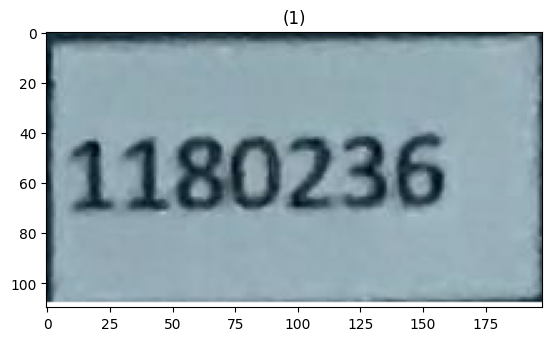

Fatma Issam Mohamed Gaballah


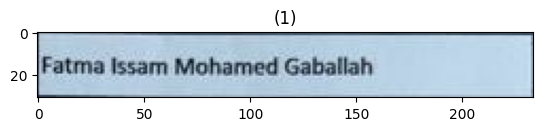

على شريف على حسب الله


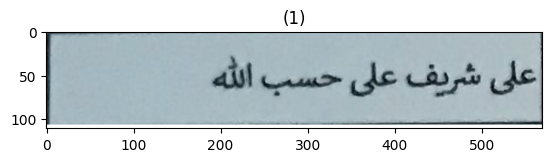

In [171]:
def getCodeOrName(img, ara=False):
	'''
	img: Original image
	ara: False for codes and english names, True for arabic name
	'''
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# get the string from the image and split it to get the wanted part
	text = ""
	if ara:
		threshImg = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
		text = pytesseract.image_to_string(threshImg, lang="ara")
	else:
		text = pytesseract.image_to_string(gray)
	return text.split('\n')[0]

img = cv2.imread("./Samples/Detection phase samples/code.png")
print(getCodeOrName(img))
show_images([img])

img = cv2.imread("./Samples/Detection phase samples/english name.png")
print(getCodeOrName(img))
show_images([img])

img = cv2.imread("./Samples/Detection phase samples/arabic name2.png")
print(getCodeOrName(img, True))
show_images([img])

In [148]:
def detectRightMark(img):
	'''
	img: Preprocessed image given to detect if it was right mark => True
	'''

	erodeKernel = np.ones((3,3),np.uint8)
	erosion = cv2.erode(img, erodeKernel, iterations=1)

	kernel = np.array([
		[0,0,0,0,0,0,1],
		[0,0,0,0,0,1,0],
		[0,0,0,0,1,0,0],
		[0,0,0,1,0,0,0],
		[0,0,1,0,0,0,0],
		[0,1,0,0,0,0,0],
		[1,0,0,0,0,0,0]
	], dtype=np.uint8)

	diagonal = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations=1)
	diagonalContours, _ = cv2.findContours(diagonal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	diagonalResult = len(diagonalContours)

	verticalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
	vertical = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, verticalKernel, iterations=1)
	verticalContours, _ = cv2.findContours(vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	verticalResult = len(verticalContours)

	return (verticalResult == 1 and diagonalResult == 1)

In [149]:
def detectVerticalLines(img):
	'''
	img: Preprocessed image given to detect if it was vertical line => number of lines
	'''

	verticalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
	vertical = cv2.morphologyEx(img, cv2.MORPH_OPEN, verticalKernel, iterations=1)
	verticalContours, _ = cv2.findContours(vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	
	return len(verticalContours)

def detectHorizontalLines(img):
	'''
	img: Preprocessed image given to detect if it was horizontal line => number of lines
	'''

	horizontalKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
	horizontal = cv2.morphologyEx(img, cv2.MORPH_OPEN, horizontalKernel, iterations=1)

	horizontalContours, _ = cv2.findContours(horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	
	return len(horizontalContours)

def detectBoxs(img):
	'''
	img: Preprocessed image given to detect if it was box => True
	'''
	verticals = detectVerticalLines(img)
	horizontals = detectHorizontalLines(img)

	return (verticals == 2 and horizontals == 2)

In [150]:
def detectQuestionMark(img):
	'''
	img: Preprocessed image given to detect if it was question mark => True
	'''
	detectedCircles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 80, param1 = 20,
																			param2 = 9, minRadius = 10, maxRadius = 17) 
	
	return detectedCircles is not None and len(detectedCircles) == 1
	# Draw the circle on the original image
	# if detectedCircles is not None:
	# 	detectedCircles = np.uint16(np.around(detectedCircles)) 
	# 	for pt in detectedCircles[0, :]: 
	# 		a, b, r = pt[0], pt[1], pt[2] 
	# 		cv2.circle(img, (a, b), r, (0, 255, 0), 2)
	# 		cv2.circle(img, (a, b), 1, (0, 0, 255), 3)

-1


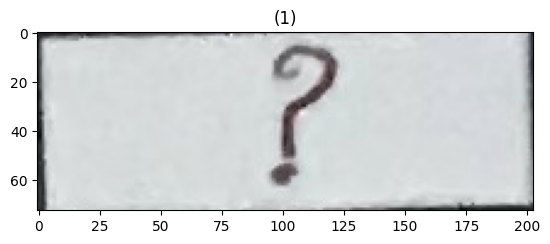

In [164]:
def detectCell(img):
	'''
	img: Original cell from the table
	return => Data of that cell after processing it
	'''
	# Preprocess the given image
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	gray = cv2.GaussianBlur(gray, (5,5), 0)
	img_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
	img_bin = 255 - img_bin
	img_bin[0:7,:] = 0
	img_bin[-7:,:] = 0
	img_bin[:, 0:20] = 0
	img_bin[:, -20:] = 0

	# Try to detect right mark
	rightMark = detectRightMark(img_bin)
	if rightMark:
		return 5
	
	# Try to detect boxes
	box = detectBoxs(img_bin)
	if box:
		return 0
	
	# Try to detect question mark
	questionMark = detectQuestionMark(img_bin)
	if questionMark:
		return -1
	
	# Try to detect minus
	horizontalLines = detectHorizontalLines(img_bin)
	if horizontalLines == 1:
		return 0
	elif horizontalLines != 0:
		return (5 - horizontalLines)
	
	verticalLines = detectVerticalLines(img_bin)
	if verticalLines != 0:
		return verticalLines

	# Else => Empty cell
	return -2


# img = cv2.imread("./Samples/Detection phase samples/question mark.png")
# img = cv2.imread("./Samples/Detection phase samples/right.png")
# img = cv2.imread("./Samples/Detection phase samples/vertical lines.png")
# img = cv2.imread("./Samples/Detection phase samples/horizontal lines.png")
# img = cv2.imread("./Samples/Detection phase samples/empty.png")
print(detectCell(img))
show_images([img])

In [ ]:
def detectNumericValues(img):
	'''
	img: Original image
	return => The number in that image
	'''
	# TODO

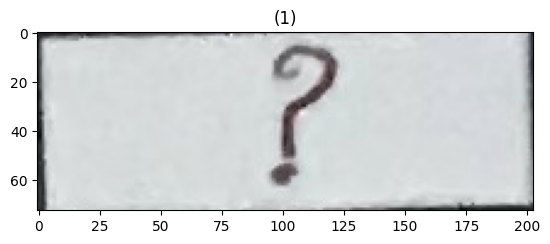

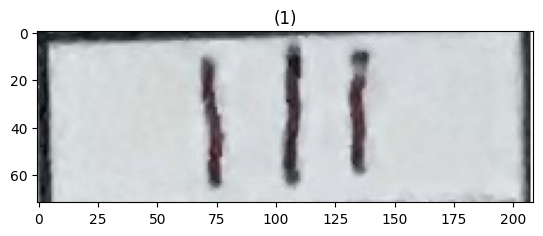

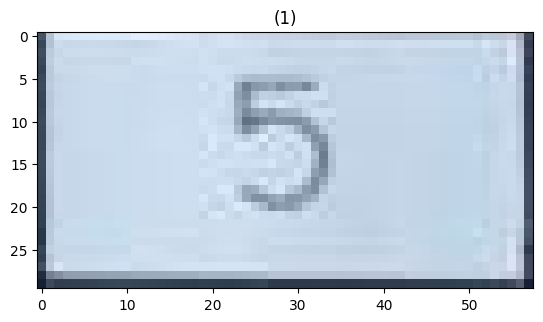

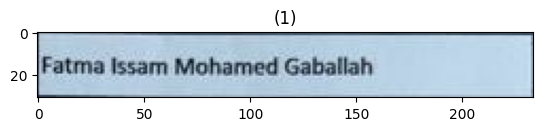

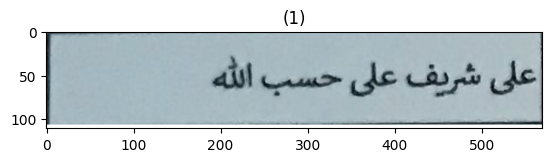

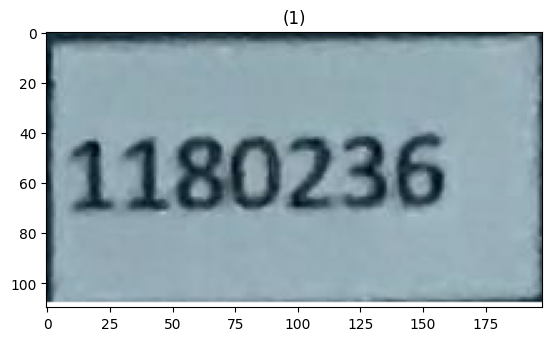

[{'Code': '1180236', 'Student Name': 'على شريف على حسب الله', 'English Name': 'Fatma Issam Mohamed Gaballah', '1': '', '2': 3, '3': -1}]


In [176]:
def detectionPhase(images):
	'''
	images: Array of cells ready to be detected
	return => Data ready to be exported to excel sheet
	'''
	
	# images[i] => 3 | images[i+1] => 2 | images[i+2] => 1
	# images[i+3] => English Name
	# images[i+4] => Student Name
	# images[i+5] => Code
	# {
	# 	"Code": ,
	# 	"Student Name": ,
	# 	"English Name": ,
	# 	"1": ,
	# 	"2": ,
	# 	"3": 
	# }

	finalData = []
	for i in range(0, len(images), 6):
		show_images([images[i]])
		show_images([images[i+1]])
		show_images([images[i+2]])
		show_images([images[i+3]])
		show_images([images[i+4]])
		show_images([images[i+5]])
		thirdCell = detectCell(images[i])
		secondCell = detectCell(images[i+1])
		firstCell = detectNumericValues(images[i+2])

		englishName = getCodeOrName(images[i+3])
		studentName = getCodeOrName(images[i+4], True)
		code = getCodeOrName(images[i+5])
		
		data = 	{
		"Code": code,
		"Student Name": studentName,
		"English Name": englishName,
		"1": firstCell,
		"2": secondCell,
		"3": thirdCell
		}
		finalData.append(data)
	
	return finalData


img1 = cv2.imread("./Samples/Detection phase samples/question mark.png")
img2 = cv2.imread("./Samples/Detection phase samples/vertical lines.png")
img3 = cv2.imread("./Samples/Detection phase samples/number.png")

img4 = cv2.imread("./Samples/Detection phase samples/english name.png")
img5 = cv2.imread("./Samples/Detection phase samples/arabic name2.png")
img6 = cv2.imread("./Samples/Detection phase samples/code.png")
images = [img1, img2, img3, img4, img5, img6]
print(detectionPhase(images))